# The conjugate gradient method


## Introduction

For convenience, we start by importing some modules needed below:

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.sparse import diags
from tqdm.notebook import tqdm

import sys
sys.path.insert(0, '../modules')
# Function to compute an error in L2 norm
from norms import l2_diff

%matplotlib inline

plt.style.use('../styles/mainstyle.use')

In the previous notebooks we have already considered several ways to iteratively solve matrix problems like $A\boldsymbol p =\boldsymbol b$.

If $A$ has some particular characteristics it's possible to devise even faster methods. Here we will assume that $A$ is symmetric and positive-definite:

\begin{equation*}
A=A^{T} \hbox{ and } \boldsymbol{p}^{T}A\boldsymbol p > 0 \hbox{ for any } \boldsymbol p\not = 0. 
\end{equation*}

The resolution of the linear system may then be viewed as a minimization problem and one of the most popular method to use in that case is the conjugate gradient method.

In this notebook we will describe the conjugate gradient method algorithm but let us first introduce some key concepts and a more primitive algorithm called the method of steepest descent.

## Projection methods

Let's consider the following quadratic functional of the vector $\boldsymbol p$,

\begin{equation*}
  J (\boldsymbol p) = \frac12\boldsymbol{p}^{T}A\boldsymbol{p} - \boldsymbol{p}^{T}\boldsymbol{b},
\end{equation*}

where $A$ is a symmetric positive-definite matrix and $\boldsymbol b$ is any vector. Then there is exactly one vector that minimizes $\boldsymbol J (\boldsymbol p)$ and this vector is the solution of the linear equation,

```{math}
:label: eq:linearSystem
  A\boldsymbol{p} = \boldsymbol{b}.
```

The proof of this statement is straightforward. Let us compute the gradient of $J$:

\begin{equation*}
  \boldsymbol{\nabla} J = A\boldsymbol{p}-\boldsymbol{b}
\end{equation*}

To get the above expression we have used $A=A^T$. The gradient of $J$ is therefore equal to zero if $A\boldsymbol{p} = \boldsymbol{b}$. Furthermore, because $A$ is positive-definite, $\boldsymbol p$ defines a minimum of $J$.

If $\boldsymbol q$ is not a solution of the linear system {eq}`eq:linearSystem`, we have:

```{math}
\boldsymbol r = \boldsymbol b - A\boldsymbol q \not = 0
```

$\boldsymbol r$ is called the **residual** and measures by how much the system is not satisfied. The residual is proportional to the gradient of $J$ and therefore indicates the direction of steepest descent along $J$.

In the projection methods we describe below, the residual is used to search for the solution. These methods are quite general and define the iteration procedure using the following formula:

```{math}
{\boldsymbol p}^{k+1}={\boldsymbol p}^k + \alpha_k {\boldsymbol d}^k
```

Similarly to the Jacobi or Gauss-Seidel methods, the iteration starts with a guess $\boldsymbol p_0$. Each method also requires a definition of the so-called search directions $\boldsymbol d_k$ and the coefficients $\alpha_k$ defining the magnitude of the jumps along the search directions.

Some projection methods are suitable for non-symmetric matrices $A$ but we don't consider them here.

## Steepest descend method

The first method we consider is the *steepest descent method*. 

We showed in the previous section that the solution of the linear system minimizes the quadratic functional $J$ and that the residual is aligned with the gradient of $J$. To rapidly lower the value of $J$, one can therefore head in that direction to go from ${\boldsymbol p}^{k}$ to ${\boldsymbol p}^{k+1}$. This is exactly what the steepest descent method does and it also chooses $\alpha_k$ so that $J({\boldsymbol p}^{k+1})$ is as small as possible. We therefore have,

```{math}
{\boldsymbol d}^{k} &= {\boldsymbol r}^{k}, \\
\frac{\partial}{\partial \alpha_k}{J({\boldsymbol p}^{k+1})}=\frac{\partial}{\partial \alpha_k}J({\boldsymbol p}^{k}+ \alpha_k {\boldsymbol r}^{k})&= 0.
```

The second condition implies that:

```{math}
\alpha_k = \frac{{\boldsymbol r}^k \cdot {\boldsymbol r}^k}{A{\boldsymbol r}^k \cdot {\boldsymbol r}^k}.
```

Let's see how this algorithm applies to the Poisson equation (with Dirichlet boundary conditions). We recall that our discretized equation reads:

```{math}
    \frac{p_{i-1,j}-2p_{i,j} + p_{i+1,j}}{\Delta x^2} + \frac{p_{i,j-1}-2p_{i,j} + p_{i,j+1}}{\Delta y^2}= b_{i,j} 
```

For the theoretical considerations developed above, the unknowns $p_{i,j}$ are grouped into a $nx-2\times ny-2$ vector $\boldsymbol p$ (for example using row major ordering). However, as we only have to know the action of the matrix on vectors, we never have to construct these 1D arrays explicitly and we can use the $(i,j)$ labeling directly (this will become clear when examining the algorithm below). There is however two conditions we need check. First, is the discretized Laplacian symmetric? If you look back at notebook `05_01_Iteration_and_2D` you will see that it is indeed the case. Second, is the corresponding matrix positive-definite? In fact, the discretized Laplacian is negative-definite because it is diagonalizable and all its eigenvalues are negative. They are given by {cite}`watkins2010`:

\begin{equation*}
  \lambda_{kl} = -4\left[\sin^2 \frac{k\pi}{2(nx-1)} + \sin^2 \frac{l\pi}{2(ny-1)}\right ],\; k=1,\ldots, nx-2,\; l=1,\ldots ny-2.
\end{equation*}

Because the the discretized Laplacian is negative-defined, we will solve the equivalent $-\nabla^2 p=-b$ instead to stay connected with the conventions adopted above. But we could also think of the steepest iterative method in terms of a maximizing problem and rephrase all the statements accordingly. 

We will solve the Poisson equation with the same grid and parameters as in notebook `05_01_Iteration_and_2D`. We also choose the same right-hand side:

```{math}
b = \sin(\pi x) \cos(\pi y) + \sin(5\pi x) \cos(5\pi y)
```

and the exact solution is again:

```{math}
p_e = -\frac{1}{2\pi^2}\sin(\pi x) \cos(\pi y) -\frac{1}{50\pi^2}\sin(5\pi x) \cos(5\pi y)
```

These two functions can be obtained by calling the corresponding Python functions we have defined in the file `iter_module.py` so we import them:

In [2]:
from iter_module import p_exact_2d, rhs_2d

The grid parameters are:

In [3]:
# Grid parameters.
nx = 101                  # number of points in the x direction
ny = 101                  # number of points in the y direction
xmin, xmax = 0.0, 1.0     # limits in the x direction
ymin, ymax = -0.5, 0.5    # limits in the y direction
lx = xmax - xmin          # domain length in the x direction
ly = ymax - ymin          # domain length in the y direction
dx = lx / (nx - 1)        # grid spacing in the x direction
dy = ly / (ny - 1)        # grid spacing in the y direction

# Create the gridline locations and the mesh grid;
# see notebook 02_02_Runge_Kutta for more details
x = np.linspace(xmin, xmax, nx)
y = np.linspace(ymin, ymax, ny)
X, Y = np.meshgrid(x, y)

# Create the source term.
b = rhs_2d(X, Y)

# Compute the exact solution.
p_exact = p_exact_2d(X, Y)

We now define a function that computes the action of $-A$ on any vector. Remember, we still use $(i, j)$ labeling so that all we need to know is $(-A\boldsymbol v)_{ij}$.

In [4]:
def A(v, dx, dy):
    """
    Computes the action of (-) the Poisson operator on any
    vector v_{ij} for the interior grid nodes
    
    Parameters
    ----------
    v : numpy.ndarray
        input vector
    dx : float
         grid spacing in the x direction
    dy : float
        grid spacing in the y direction
        

    Returns
    -------
    Av : numpy.ndarray
        action of A on v
    """
    
    Av = -((v[:-2, 1:-1]-2.0*v[1:-1, 1:-1]+v[2:, 1:-1])/dx**2 
       + (v[1:-1, :-2]-2.0*v[1:-1,1:-1]+v[1:-1, 2:])/dy**2)
    
    return Av

Let's now compute the initial guess and create storages for the residual $r$ and $A(r)$:

In [5]:
# Initial guess
p0 = np.zeros((nx, ny))

# Place holders for the residual r and A(r)
r = np.zeros((nx, ny))
Ar = np.zeros((nx, ny))

We then specify our convergence parameters:

In [6]:
tolerance = 1e-10
max_it = 20000

And we are now ready to iterate:

In [7]:
pbar = tqdm(total=max_it)
pbar.set_description("iter / max_it");

it = 0 # iteration counter
diff = 1.0
tol_hist_jac = []

p = p0.copy()

while (diff > tolerance):
    if it > max_it:
        print('\nSolution did not converged within the maximum'
              ' number of iterations'
              f'\nLast l2_diff was: {diff:.5e}')
        break
    
    # Residual
    r[1:-1, 1:-1] = -b[1:-1, 1:-1] - A(p, dx, dy)
    # Laplacian of the residual
    Ar[1:-1, 1:-1] = A(r, dx, dy)
    # Magnitude of jump
    alpha = np.sum(r*r) / np.sum(r*Ar)
    # Iterated solution
    pnew = p + alpha*r

    diff = l2_diff(pnew, p)
    tol_hist_jac.append(diff)
    
    # Get ready for next iteration
    it += 1
    np.copyto(p, pnew)
    
    # We update our progress bar
    pbar.update(1)

else:
    print(f'\nThe solution converged after {it} iterations')

# When the progress bar will not be used
# further, it has to be closed
pbar.close()


The solution converged after 12154 iterations



We can measure the accuracy of our solution with the same diagnostics as above.

In [8]:
diff = l2_diff(pnew, p_exact)
print(f'The l2 difference between the computed solution '
      f'and the exact solution is:\n{diff}')

The l2 difference between the computed solution and the exact solution is:
1.3690442902216607e-07


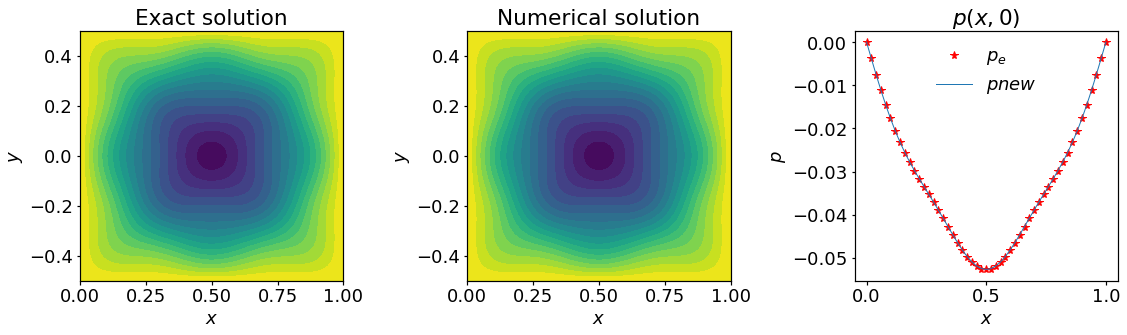

In [9]:
fig, (ax_1, ax_2, ax_3) = plt.subplots(1, 3, figsize=(16,5))
# We shall now use the
# matplotlib.pyplot.contourf function.
# As X and Y, we pass the mesh data.
#
# For more info
# https://matplotlib.org/3.1.1/api/_as_gen/matplotlib.pyplot.contourf.html
#
ax_1.contourf(X, Y, pnew, 20)
ax_2.contourf(X, Y, p_exact, 20)

# plot along the line y=0:
jc = int(ly/(2*dy))
ax_3.plot(x, p_exact[:,jc], '*', color='red', markevery=2, label=r'$p_e$')
ax_3.plot(x, pnew[:,jc], label=r'$pnew$')

# add some labels and titles
ax_1.set_xlabel(r'$x$')
ax_1.set_ylabel(r'$y$')
ax_1.set_title('Exact solution')

ax_2.set_xlabel(r'$x$')
ax_2.set_ylabel(r'$y$')
ax_2.set_title('Numerical solution')

ax_3.set_xlabel(r'$x$')
ax_3.set_ylabel(r'$p$')
ax_3.set_title(r'$p(x,0)$')

ax_3.legend();

This looks good: we have converged close to the exact solution. The bad news is that if you time the solution you will see that it more than two times slower than the Jacobi method. This is not a big surprise as the algorithm needs two evaluations of $A(v)$ per iteration. But the good news is that by changing the algorithm a bit, we can drastically cut the number of iterations. To that end, let us discuss the conjugate gradient algorithm.

## Conjugate gradient method

With steepest descent, we use the residual as the search direction. If you compute ${\boldsymbol r}^{k+1}\cdot {\boldsymbol r}^k$ you will see that two successive residuals are orthogonal and so are the search directions. But there is nothing to prevent the algorithm from making several jumps in the same (or a similar) direction.  Imagine you wanted to go from the intersection of the 5th avenue and 23rd street to the intersection of the 9th avenue and 30th street. Knowing that each segment costs the same number of computations (one iteration), would you follow the red path or green path?

<img src="../figures/jumps.png" width=350>

The conjugate gradient method is built upon the idea of reducing the number of jumps and make sure the algorithm never selects the same direction twice. To achieve this, one needs the following choices for the size of the jumps and search directions:

```{math}
\alpha^n &= \frac{{\boldsymbol r}^n \cdot {\boldsymbol r}^n}{A{\boldsymbol d}^n \cdot {\boldsymbol d}^n} \\
{\boldsymbol d}^{n+1}&={\boldsymbol r}^{n+1}+\beta^{n+1}{\boldsymbol d}^{n}, \hbox{ with } \beta^{n+1} = \frac{{\boldsymbol r}^{n+1} \cdot {\boldsymbol r}^{n+1}}{{\boldsymbol r}^n \cdot {\boldsymbol r}^n}\\ \hbox{ and } {\boldsymbol d}^{0} &= {\boldsymbol r}^{0}.
```

Obviously, the search directions are no longer equal to the residuals but they are a linear combination of the residual and the previous search direction. What is remarkable about this algorithm is that the residual at iteration $k+1$ is orthogonal not only to the previous residual but to all of them. As a vector space of dimension $n$ can only contain $n$ orthogonal vectors, we immediately conclude that the conjugate gradient method necessarily converges (remember the restriction we put on $A$ though)! The derivation of the properties of the conjugate gradient method can cause some severe headaches. However, they are beautifully explained in this elegant paper: {cite}`Shewchuk1994`. Here we only apply the algorithm to our sample problem and refer the interested reader to this paper.

A possible implementation of the method is as follows:

In [10]:
# Initial guess
p0 = np.zeros((nx, ny))

# Place holders for the residual r and A(d)
r = np.zeros((nx, ny))
Ad = np.zeros((nx, ny))

In [11]:
tolerance = 1e-10
max_it = 100

pbar = tqdm(total=max_it)
pbar.set_description("iter / max_it");

it = 0 # iteration counter
diff = 1.0
tol_hist_jac = []

p = p0.copy()

# Initial residual r0 and initial search direction d0
r[1:-1, 1:-1] = -b[1:-1, 1:-1] - A(p, dx, dy)
d = r.copy()

while (diff > tolerance):
    if it > max_it:
        print('\nSolution did not converged within the maximum'
              ' number of iterations'
              f'\nLast l2_diff was: {diff:.5e}')
        break

    # Laplacian of the search direction.
    Ad[1:-1, 1:-1] = A(d, dx, dy)
    # Magnitude of jump.
    alpha = np.sum(r*r) / np.sum(d*Ad)
    # Iterated solution
    pnew = p + alpha*d
    # Intermediate computation
    beta_denom = np.sum(r*r)
    # Update the residual.
    r = r - alpha*Ad
    # Compute beta
    beta = np.sum(r*r) / beta_denom
    # Update the search direction.
    d = r + beta*d
    
    diff = l2_diff(pnew, p)
    tol_hist_jac.append(diff)
    
    # Get ready for next iteration
    it += 1
    np.copyto(p, pnew)
    
    # We update our progress bar
    pbar.update(1)

else:
    print(f'\nThe solution converged after {it} iterations')

# When the progress bar will not be used
# further, it has to be closed
pbar.close()


The solution converged after 3 iterations



You are not mistaken, it only took 3 iterations to reach the desired tolerance! This is a rather a special case because the right-hand side of the equation is simple. But you can try other choices and still observe the conjugate gradient method to be much faster than the steepest descent method.

To be sure, let's measure the accuracy of our solution using our usual diagnostics:

In [12]:
diff = l2_diff(pnew, p_exact)
print(f'The l2 difference between the computed solution '
      f'and the exact solution is:\n{diff}')

The l2 difference between the computed solution and the exact solution is:
2.890080056046258e-08


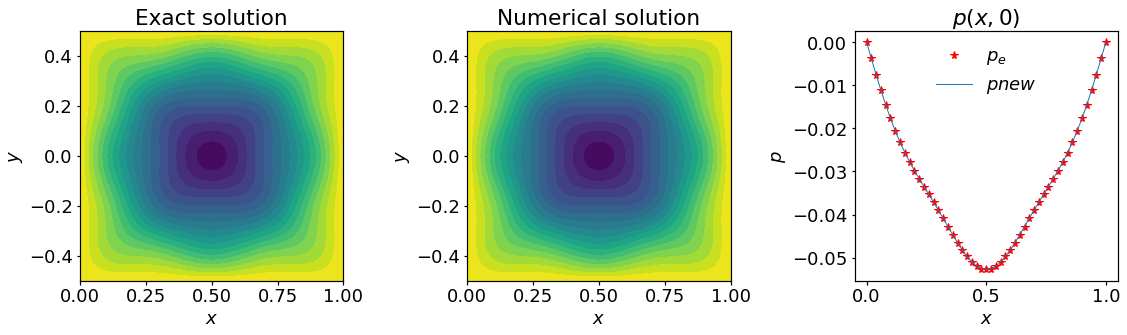

In [13]:
fig, (ax_1, ax_2, ax_3) = plt.subplots(1, 3, figsize=(16,5))
# We shall now use the
# matplotlib.pyplot.contourf function.
# As X and Y, we pass the mesh data.
#
# For more info
# https://matplotlib.org/3.1.1/api/_as_gen/matplotlib.pyplot.contourf.html
#
ax_1.contourf(X, Y, pnew, 20)
ax_2.contourf(X, Y, p_exact, 20)

# plot along the line y=0:
jc = int(ly/(2*dy))
ax_3.plot(x, p_exact[:,jc], '*', color='red', markevery=2, label=r'$p_e$')
ax_3.plot(x, pnew[:,jc], label=r'$pnew$')

# add some labels and titles
ax_1.set_xlabel(r'$x$')
ax_1.set_ylabel(r'$y$')
ax_1.set_title('Exact solution')

ax_2.set_xlabel(r'$x$')
ax_2.set_ylabel(r'$y$')
ax_2.set_title('Numerical solution')

ax_3.set_xlabel(r'$x$')
ax_3.set_ylabel(r'$p$')
ax_3.set_title(r'$p(x,0)$')

ax_3.legend();

## Summary

In this notebook we provided an illustration of methods known as projection methods. They are called in this way because the jump from one iteration to the next one is along specific search directions.

The method of steepest descent and the conjugate gradient methods are basic methods belonging to this class. The literature on this topic is vast and there exists a large collection of sophisticated methods tailored to many specific cases. Here we have only scratched the surface.

The last notebook of this chapter will be devoted to a programming topic. As promised, we will show you how to speed up your Python code when you cannot rely directly on some precompiled function available in `numpy` or `scipy`.

## References
```{bibliography} biblio.bib
:filter: docname in docnames
```